# Advanced SEIR

Parameteres:
- N = number of elemements in the population
- sim_days = number of days to run the simulation for
- orig_infected = number of individuals infected by the desease on the first day
- beta = average amount of people an infected element can be able to infect in a day
- days = number of days the desease lasts (how many days is someone contageous)
- inc_days = number of incubation days for the desease to become contageus
- S(t) = number of susceptible elements at time t
- E(t) = number of esposed elements at time t
- I(t) = number of infected elements at time t
- R(t) = number of recovered elements at time t
- gamma = percentage of how many individuals recover from the desease each day
- delta = percentage of how many individuals move from the incubaation period to being infected
- R0 = total number of people an infected individual infects while being ill
- alpha = percentage of people dying if positive
- death_days = number of days from infection from death

In this example, both alpha and R0 have been made time variant using a scaling function and the logistic

In [1]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [358]:
def r_time(t, R0_beg, R0_end, dec_factor, x0):
    adaptive_r = ((R0_beg-R0_end)/(1+np.exp(-dec_factor*(-t+x0)))) + R0_end
    return adaptive_r

def alpha(scaling, I, N, opt_alpha):
        return scaling * (I/N) + opt_alpha

def ad_seir_step_ahead(y, t, N, gamma, delta, scaling, opt_alpha, rho, R0_beg, R0_end, dec_factor, x):
    S, E, I, R, D = y
    r_t = r_time(t, R0_beg, R0_end, dec_factor, x)
    alpha_t = alpha(scaling, I, N, opt_alpha)
    beta_t = r_t * (1/(alpha_t*(1/rho)+(1-alpha_t)*(1/gamma)))
    dsdt = -beta_t * I * (S / N)
    dedt = beta_t * I * (S / N) - delta * E
    didt = delta * E - (1 - alpha_t) * gamma * I - alpha_t * rho * I
    drdt = (1 - alpha_t) * gamma * I
    dddt = alpha_t * rho * I
    return dsdt, dedt, didt, drdt, dddt

def ad_SEIR_sim(N, sim_days, orig_esposed, days, inc_days, scaling, opt_alpha, death_days, 
                R0_beg, R0_end, dec_factor, x):
    # Initial conditions: S0, E0, I0, R0, D0
    y0 = N-orig_esposed, orig_esposed, 0, 0, 0
    gamma = 1.0 / days
    delta = 1.0 / inc_days
    rho = 1.0 / death_days
    t = np.linspace(0, sim_days-1, sim_days)
    r_t = [r_time(i, R0_beg, R0_end, dec_factor, x) for i in range(len(t))]
    sim_res = odeint(ad_seir_step_ahead, y0, t, args=(N, gamma, delta, scaling, opt_alpha,
                                                      rho, R0_beg, R0_end, dec_factor, x))
    S, E, I, R, D = sim_res.T
    alpha_t = [alpha(scaling, i, N, opt_alpha) for i in I]
    return S, E, I, R, D, r_t, alpha_t

def r_time2(t, sim_days, scale_factor):
    return scale_factor*np.sin(t/(sim_days/10))+scale_factor +1

def ad_seir_step_ahead2(y, t, N, gamma, delta, scaling, opt_alpha, rho, sim_days, scale_factor):
    S, E, I, R, D = y
    r_t = r_time2(t, sim_days, scale_factor)
    alpha_t = alpha(scaling, I, N, opt_alpha)
    beta_t = r_t * (1/(alpha_t*(1/rho)+(1-alpha_t)*(1/gamma)))
    dsdt = -beta_t * I * (S / N)
    dedt = beta_t * I * (S / N) - delta * E
    didt = delta * E - (1 - alpha_t) * gamma * I - alpha_t * rho * I
    drdt = (1 - alpha_t) * gamma * I
    dddt = alpha_t * rho * I
    return dsdt, dedt, didt, drdt, dddt

def ad_SEIR_sim2(N, sim_days, orig_esposed, days, inc_days, scaling, opt_alpha, death_days, scale_factor):
    # Initial conditions: S0, E0, I0, R0, D0
    y0 = N-orig_esposed, orig_esposed, 0, 0, 0
    gamma = 1.0 / days
    delta = 1.0 / inc_days
    rho = 1.0 / death_days
    t = np.linspace(0, sim_days-1, sim_days)
    r_t = [r_time2(i, sim_days, scale_factor) for i in range(len(t))]
    sim_res = odeint(ad_seir_step_ahead2, y0, t, args=(N, gamma, delta, scaling, opt_alpha,
                                                      rho, sim_days, scale_factor))
    S, E, I, R, D = sim_res.T
    alpha_t = [alpha(scaling, i, N, opt_alpha) for i in I]
    return S, E, I, R, D, r_t, alpha_t

In [359]:
N = 1000
sim_days = 100
orig_infected = 7
days = 14
inc_days = 1
death_days = 8
# dec_factor between 0.1 and 1
R0_beg, R0_end, dec_factor, x = 6, 1, 0.1, 40
scaling = 0.01
# Age groups = 0-20, 20-50, 50-70, 70-110
age_based_alpha = [0.05, 0.1, 0.3, 0.5]
pop_age_prop = [0.15, 0.25, 0.4, 0.2]
opt_alpha = sum([i*j for i, j in zip(age_based_alpha, pop_age_prop)])
scale_factor = 1

# S, E, I, R, D, R0_time, alpha_time = ad_SEIR_sim(N, sim_days, orig_infected, days, 
#                           inc_days, scaling, opt_alpha, death_days, R0_beg, R0_end, dec_factor, x)

S, E, I, R, D, R0_time, alpha_time = ad_SEIR_sim2(N, sim_days, orig_infected, days, 
                          inc_days, scaling, opt_alpha, death_days, scale_factor)

In [423]:
# def ad_SEIR_plot(negatives, esposed, positives, survivors, deths, R0, alpha):
#     fig = go.Figure(
#         data=[go.Scatter(x=[i for i in range(len(negatives))], y=negatives,
#                          mode="lines", name='Susceptible',
#                          line=dict(width=2, color="blue")),
#               go.Scatter(x=[i for i in range(len(negatives))], y=esposed,
#                          mode="lines", name='Esposed',
#                          line=dict(width=2, color="red")),
#               go.Scatter(x=[i for i in range(len(negatives))], y=positives,
#                          mode="lines", name='Infected',
#                          line=dict(width=2, color="green")),
#               go.Scatter(x=[i for i in range(len(negatives))], y=deths,
#                          mode="lines", name='Deths',
#                          line=dict(width=2, color="black")),
#              go.Scatter(x=[i for i in range(len(negatives))], y=survivors,
#                          mode="lines", name='Recovered',
#                          line=dict(width=2, color="orange"))],
#             layout=go.Layout(
#             title_text="Advanced SEIR Model (Avg R<sub>0</sub>="+ str(round(np.mean(R0), 2))+ ', α=' + str(round(np.mean(alpha), 3))+ ')', hovermode="closest",
#             updatemenus= [
#                 {
#                     "buttons": [
#                         {
#                             "args": [None, {"frame": {"duration": 100, "redraw": False},
#                                             "fromcurrent": True, 
#                                             "transition": {"duration": 10,
#                                                            "easing": "quadratic-in-out"}}],
#                             "label": "Play",
#                             "method": "animate"
#                         },
#                         {
#                             "args": [[None], {"frame": {"duration": 0, "redraw": False},
#                                               "mode": "immediate",
#                                               "transition": {"duration": 0}}],
#                             "label": "Pause",
#                             "method": "animate"
#                         }
#                     ],
#                     "direction": "left",
#                     "pad": {"r": 10, "t": 87},
#                     "showactive": False,
#                     "type": "buttons",
#                     "x": 0.14,
#                     "xanchor": "right",
#                     "y": 1.65,
#                     "yanchor": "top"
#                 }
#             ]),

#         frames=[go.Frame(
#             data=[go.Scatter(
#                 x=[i for i in range(k)],
#                 y=negatives,
#                 mode="lines",
#                 line=dict(width=2, color="blue")),
#                  go.Scatter(
#                 x=[i for i in range(k)],
#                 y=esposed,
#                 mode="lines",
#                 line=dict(width=2, color="red")),
#                  go.Scatter(
#                 x=[i for i in range(k)],
#                 y=positives,
#                 mode="lines",
#                 line=dict(width=2, color="green")),
#                  go.Scatter(
#                 x=[i for i in range(k)],
#                 y=deths,
#                 mode="lines",
#                 line=dict(width=2, color="black")),
#                  go.Scatter(
#                 x=[i for i in range(k)],
#                 y=survivors,
#                 mode="lines",
#                 line=dict(width=2, color="orange"))], 
#                 layout=go.Layout(
#                     annotations=[dict(
#                                                     text="                    R<sub>0</sub>="+ str(round(R0[k], 2)), 
#                                                    showarrow=False,
#                                                     arrowhead=0,
#                                                    font=dict(
#                                                         color="black",
#                                                         size=18
#                                                     ),
#                                                     xshift=302,
#                                                     yshift=-6
#                                                     ),
#                                 dict(
#                                                     text="                    α<sub>0</sub>="+ str(round(alpha[k], 3)), 
#                                                    showarrow=False,
#                                                     arrowhead=0,
#                                                    font=dict(
#                                                         color="black",
#                                                         size=18
#                                                     ),
#                                                     xshift=304,
#                                                     yshift=-27)
#                                 ]))

#             for k in range(len(negatives))]

#     )
#     fig.update_xaxes(title_text="Number of Days")
#     fig.update_yaxes(title_text="Number of Cases")
#     fig.show()

In [424]:
# ad_SEIR_plot(S, E, I, R, D, R0_time, alpha_time)

In [421]:
def ad_SEIR_plot(negatives, esposed, positives, survivors, deths, R0, alpha):
    fig = make_subplots(rows=2, cols=2, 
                       specs=[[{"colspan": 2}, None], [{ }, { }]], horizontal_spacing = 0.2)

    fig.add_trace(
        go.Scatter(x=[i for i in range(len(negatives))], y=negatives,
                         mode="lines", name='Susceptible',
                         line=dict(width=2, color="blue")),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(x=[i for i in range(len(negatives))], y=esposed,
                         mode="lines", name='Esposed',
                         line=dict(width=2, color="red")),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(x=[i for i in range(len(negatives))], y=positives,
                         mode="lines", name='Infected',
                         line=dict(width=2, color="green")),
        row=1, col=1
    )
    
    fig.add_trace(
        go.Scatter(x=[i for i in range(len(negatives))], y=deths,
                         mode="lines", name='Deths',
                         line=dict(width=2, color="black")),
        row=1, col=1
    )
        
    fig.add_trace(
        go.Scatter(x=[i for i in range(len(negatives))], y=survivors,
                         mode="lines", name='Recovered',
                         line=dict(width=2, color="orange")),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(x=[i for i in range(len(negatives))], y=R0,
                                 mode="lines", name='R0 Landscape',
                                 line=dict(width=2)),
        row=2, col=1)

    fig.add_trace(
        go.Scatter(x=[i for i in range(len(negatives))], y=alpha,
                                 mode="lines", name='α Landscape',
                                 line=dict(width=2)),
        row=2, col=2)

    frames=[go.Frame(
            data=[go.Scatter(
                x=[i for i in range(k)],
                y=negatives,
                mode="lines",
                line=dict(width=2, color="blue")),
                 go.Scatter(
                x=[i for i in range(k)],
                y=esposed,
                mode="lines",
                line=dict(width=2, color="red")),
                 go.Scatter(
                x=[i for i in range(k)],
                y=positives,
                mode="lines",
                line=dict(width=2, color="green")),
                 go.Scatter(
                x=[i for i in range(k)],
                y=deths,
                mode="lines",
                line=dict(width=2, color="black")),
                 go.Scatter(
                x=[i for i in range(k)],
                y=survivors,
                mode="lines",
                line=dict(width=2, color="orange")), 
                go.Scatter(
                x=[i for i in range(k)],
                y=R0,
                mode="lines",
                line=dict(width=2)), 
                go.Scatter(
                x=[i for i in range(k)],
                y=alpha,
                mode="lines",
                line=dict(width=2))], 
                layout=go.Layout(
                    annotations=[dict(
                                                    text="                    R<sub>0</sub>="+ str(round(R0[k], 2)), 
                                                   showarrow=False,
                                                    arrowhead=0,
                                                   font=dict(
                                                        color="black",
                                                        size=18
                                                    ),
                                                    xshift=282,
                                                    yshift=-75
                                                    ),
                                dict(
                                                    text="                    α<sub>0</sub>="+ str(round(alpha[k], 3)), 
                                                   showarrow=False,
                                                    arrowhead=0,
                                                   font=dict(
                                                        color="black",
                                                        size=18
                                                    ),
                                                    xshift=284,
                                                    yshift=-97)
                                ]),

                traces=[0,1,2,3,4,5,6,7])

            for k in range(len(negatives))]
    
    fig.frames=frames
        
    fig.update_layout(updatemenus= [
                {
                    "buttons": [
                        {
                            "args": [None, {"frame": {"duration": 100, "redraw": False},
                                            "fromcurrent": True, 
                                            "transition": {"duration": 10,
                                                           "easing": "quadratic-in-out"}}],
                            "label": "Play",
                            "method": "animate"
                        },
                        {
                            "args": [[None], {"frame": {"duration": 0, "redraw": False},
                                              "mode": "immediate",
                                              "transition": {"duration": 0}}],
                            "label": "Pause",
                            "method": "animate"
                        }
                    ],
                    "direction": "left",
                    "pad": {"r": 10, "t": 87},
                    "showactive": False,
                    "type": "buttons",
                    "x": 0.14,
                    "xanchor": "right",
                    "y": 1.4,
                    "yanchor": "top"
                }
            ],)

    fig.update_layout(height=600, width=800, 
                      title_text="Advanced SEIR Model (Avg R<sub>0</sub>="+ str(round(np.mean(R0), 2))+ ', α=' + str(round(np.mean(alpha), 3))+ ')')
    fig.update_xaxes(title_text="Days", row=1, col=1)
    fig.update_yaxes(title_text="Number of Cases", row=1, col=1)
    fig.update_yaxes(title_text="R<sub>0</sub>", row=2, col=1)
    fig.update_xaxes(title_text="Days",  row=2, col=1)
    fig.update_yaxes(title_text="α", row=2, col=2)
    fig.update_xaxes(title_text="Days",  row=2, col=2)
    fig.show()

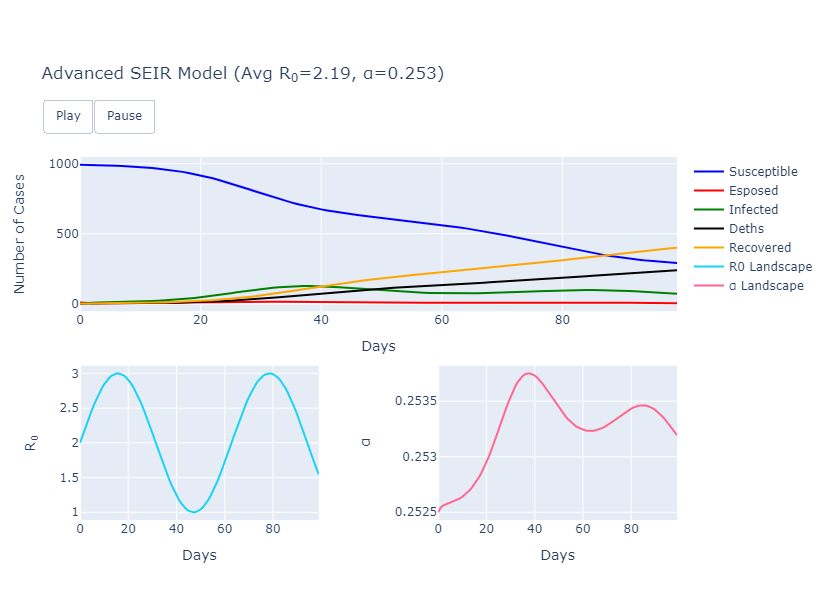

In [422]:
ad_SEIR_plot(S, E, I, R, D, R0_time, alpha_time)